## 1. load the packages

In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.preprocessing import StandardScaler,MinMaxScaler, LabelEncoder
from sklearn.model_selection import StratifiedKFold, cross_val_score,GridSearchCV,train_test_split
from sklearn.metrics import accuracy_score,confusion_matrix,roc_auc_score,roc_curve
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from scipy.stats import f_oneway

import os
import time
SEED=72
import warnings
warnings.filterwarnings('ignore')

In [4]:
import optuna
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel

from xgboost import XGBClassifier

## 2. import dataset

In [5]:
data = '../data/TrainOnMe-1d3c80f1-d0b9-436e-9bcf-f50f94c66e0b.csv'
df = pd.read_csv(data,index_col=0)

## 3.EDA

In [18]:
print(df.shape)
print(df['y'].unique())

(5000, 14)
['Antrophic' 'OpenAI' 'Mistral']


In [20]:
df.head()

y         x1       x2         x3       x4         x5         x6  \
0  Antrophic  199.84675 -0.22935  -94.57266 -0.90297  229.65733 -119.73784   
1     OpenAI  199.76663  0.57961  -98.69548 -0.89087  229.58771 -117.92856   
2  Antrophic  200.40804 -0.03834  -97.64719 -0.89971  230.20797 -121.71234   
3  Antrophic  201.38523  0.51942 -105.16820 -0.89226  231.15781 -120.69422   
4     OpenAI  199.60130 -0.76663  -94.42670 -0.88284  229.39822 -122.24543   

   x7       x8       x9       x10      x11   x12        x13  
0  Q4  0.12045  0.50670  13.31960  2.86055  True  951.94743  
1  Q4 -0.28505  0.16832  14.52734 -0.51453  True  949.48540  
2  Q3 -0.13753  0.71530   9.90651  0.35612  True  953.21660  
3  Q2  0.03872 -0.37550  11.10684  1.32156  True  954.34203  
4  Q4  0.46721  2.14220   9.72683 -4.96100  True  950.79316

:point_right:view summary of the dataset

In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5000 entries, 0 to 4999
Data columns (total 14 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   y       5000 non-null   object 
 1   x1      5000 non-null   float64
 2   x2      5000 non-null   float64
 3   x3      5000 non-null   float64
 4   x4      5000 non-null   float64
 5   x5      5000 non-null   float64
 6   x6      5000 non-null   float64
 7   x7      5000 non-null   object 
 8   x8      5000 non-null   float64
 9   x9      5000 non-null   float64
 10  x10     5000 non-null   float64
 11  x11     5000 non-null   float64
 12  x12     5000 non-null   bool   
 13  x13     5000 non-null   float64
dtypes: bool(1), float64(11), object(2)
memory usage: 551.8+ KB


:point_right: frequency distribution of values in categorical variables and labels.

In [10]:
col_names=['y','x7','x12']
for col in col_names:
    print(df[col].value_counts())

OpenAI       2039
Antrophic    1577
Mistral      1384
Name: y, dtype: int64
Q4       1722
Q3       1651
Boom!     768
Q2        719
Q1        140
Name: x7, dtype: int64
True    5000
Name: x12, dtype: int64


In [26]:
df[df=='Boom!'].count()

y        0
x1       0
x2       0
x3       0
x4       0
x5       0
x6       0
x7     768
x8       0
x9       0
x10      0
x11      0
x12      0
x13      0
dtype: int64

:eyes:
1. there are 13 variables in the dataset, including continuous, categorical and boolean values
2. there are 3 labels of the target which are "'Antrophic' 'OpenAI' 'Mistral'", so it is a classification problem
3. :exclamation:the dataset is **not perfectly balanced**, which may lead to a bias toward the majority class `OpenAI`

:point_right:missing values

In [24]:
df.isna().sum()

y      0
x1     0
x2     0
x3     0
x4     0
x5     0
x6     0
x7     0
x8     0
x9     0
x10    0
x11    0
x12    0
x13    0
dtype: int64

:eyes: :smile:there are no missing values in this dataset!

:point_right: statistics description of the dataset

In [27]:
df.describe()

x1           x2           x3           x4           x5  \
count  5000.000000  5000.000000  5000.000000  5000.000000  5000.000000   
mean    200.024178     0.008813  -100.048286    -0.889050   229.823198   
std       0.996196     0.701796     3.166388     0.006994     0.995935   
min     196.980120    -2.557330  -112.221780    -0.910870   226.749730   
25%     199.325927    -0.470495  -102.115178    -0.893730   229.126792   
50%     200.003570     0.009440  -100.050305    -0.888825   229.803295   
75%     200.713703     0.489422   -97.912615    -0.883667   230.511915   
max     203.545120     2.357430   -89.392710    -0.872220   233.335580   

                x6           x8           x9          x10          x11  \
count  5000.000000  5000.000000  5000.000000  5000.000000  5000.000000   
mean   -120.715127    -0.009455    -0.002725    11.063009    -0.368877   
std       1.797866     1.249162     1.222523     2.758224     3.381583   
min    -127.194620    -4.528530    -4.553040     0.580400   -13.345840   
25%    -121.939595    -0.751483    -0.754215     9.272417    -2.623135   
50%    -120.733120    -0.024595    -0.011600    10.977415    -0.505355   
75%    -119.481063     0.745343     0.745553    12.854080     1.783340   
max    -113.704370     5.666690     5.091260    22.314140    11.793260   

               x13  
count  5000.000000  
mean    950.096747  
std       4.864654  
min     935.059800  
25%     946.687768  
50%     949.988875  
75%     953.418130  
max     969.307150

1. before visualization, we need to normalization or standardization because differences between values of features are very high to observe on plot.
2. check outliers

In [6]:
# using min-max scaling to scale the data
scaler = MinMaxScaler()
df_scaled = df.copy()
numeric_cols = df_scaled.select_dtypes(include=[np.number]).columns.tolist()
df_scaled[numeric_cols] = scaler.fit_transform(df_scaled[numeric_cols])

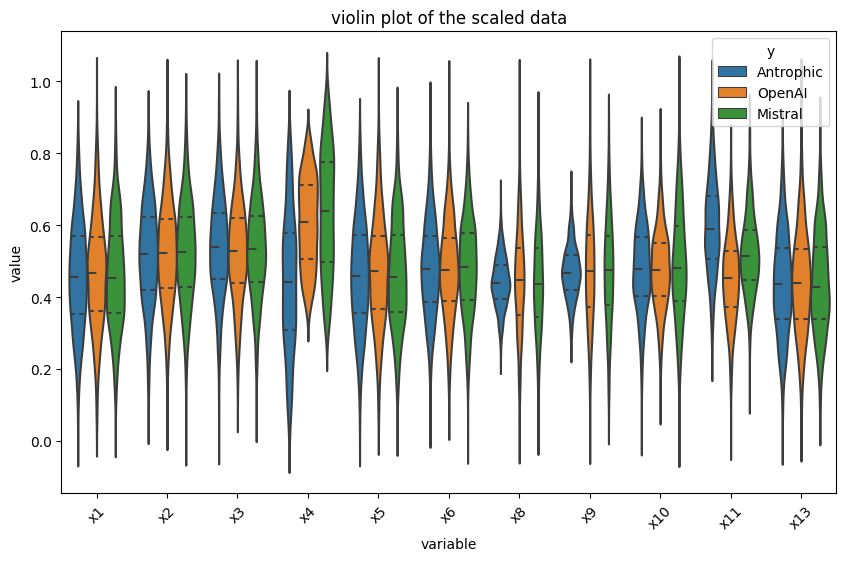

In [47]:
melt_df = pd.melt(df_scaled, id_vars=['y'], value_vars=numeric_cols)
plt.figure(figsize=(10,6))
sns.violinplot(data=melt_df,hue="y",x='variable',y='value',inner="quart",dodge=True)     
plt.xticks(rotation=45)
plt.title('violin plot of the scaled data')
plt.show()

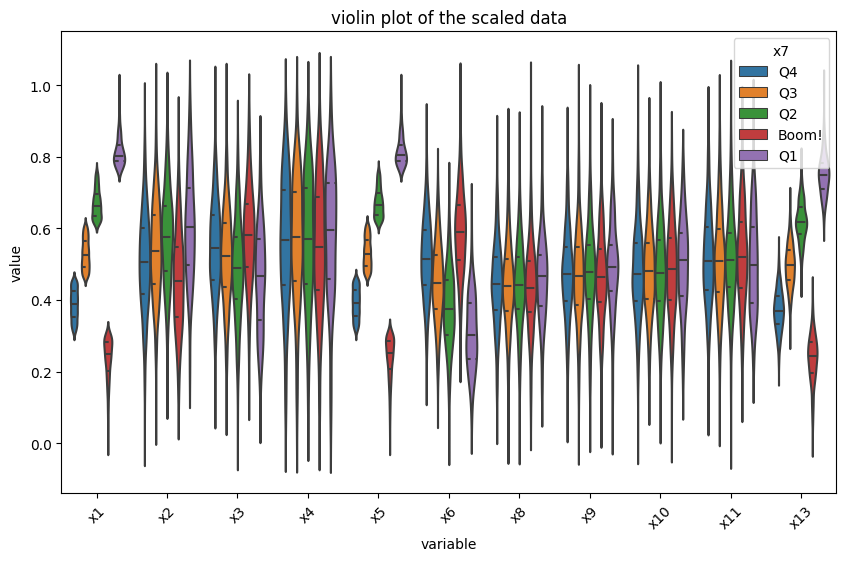

In [11]:
melt_df = pd.melt(df_scaled, id_vars=['x7'], value_vars=numeric_cols)
plt.figure(figsize=(10,6))
sns.violinplot(data=melt_df,hue="x7",x='variable',y='value',inner="quart",dodge=True)     
plt.xticks(rotation=45)
plt.title('violin plot of the scaled data')
plt.show()

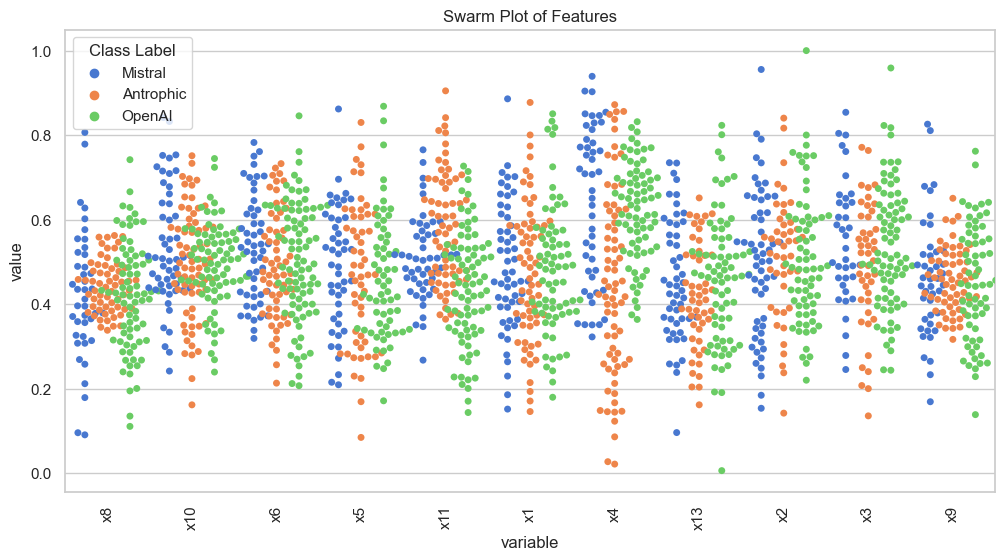

In [97]:
sns.set(style="whitegrid", palette="muted")

# Reduce points if dataset is large
sample_melt_df = melt_df.sample(2000)

# Plot
plt.figure(figsize=(12, 6))
sns.swarmplot(x='variable', y='value', hue='y', data=sample_melt_df, dodge=True)
plt.xticks(rotation=90)
plt.title("Swarm Plot of Features")
plt.legend(title="Class Label")
plt.show()

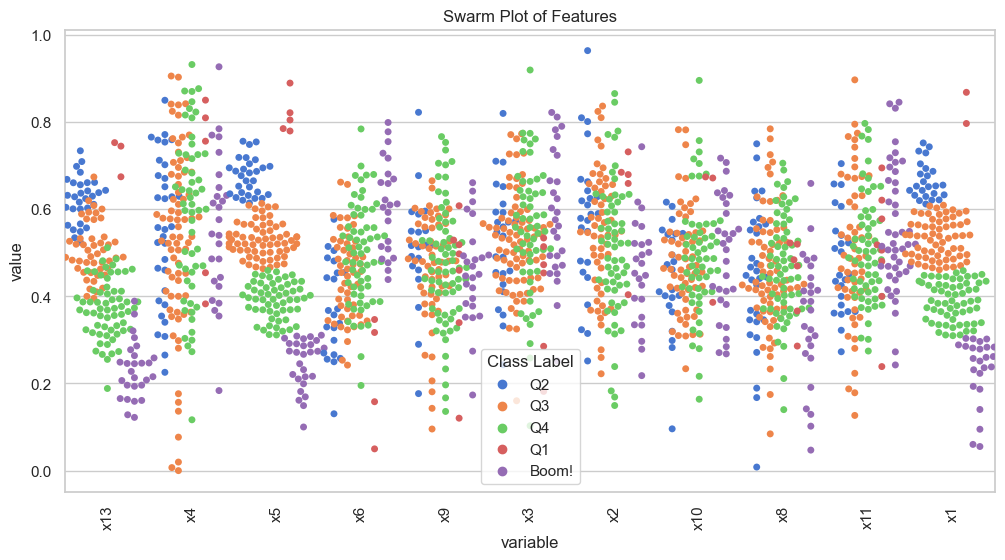

In [12]:
sns.set(style="whitegrid", palette="muted")

# Reduce points if dataset is large
sample_melt_df = melt_df.sample(2000)

# Plot
plt.figure(figsize=(12, 6))
sns.swarmplot(x='variable', y='value', hue='x7', data=sample_melt_df, dodge=True)
plt.xticks(rotation=90)
plt.title("Swarm Plot of Features")
plt.legend(title="Class Label")
plt.show()

:eyes:

1. **Feature separation**:  in `x4`,`x11` variable, the 3 labels look like separated, so it can be good for classification; some features (`x3`,`x6`,`x10`) show overlapping distributions, suggesting these features may not strongly differentiate between classes
2. **Symmetric vs. Asymmetric Distributions**: some features(e.g.`x5`,`x10`) show `symmertical distributions`, indicating a normal-like spread, others (e.g. `x8`,`x9`) are `asymmetrical`, meaning they could have skewness
3. all the features look not clear separately in terms of classification


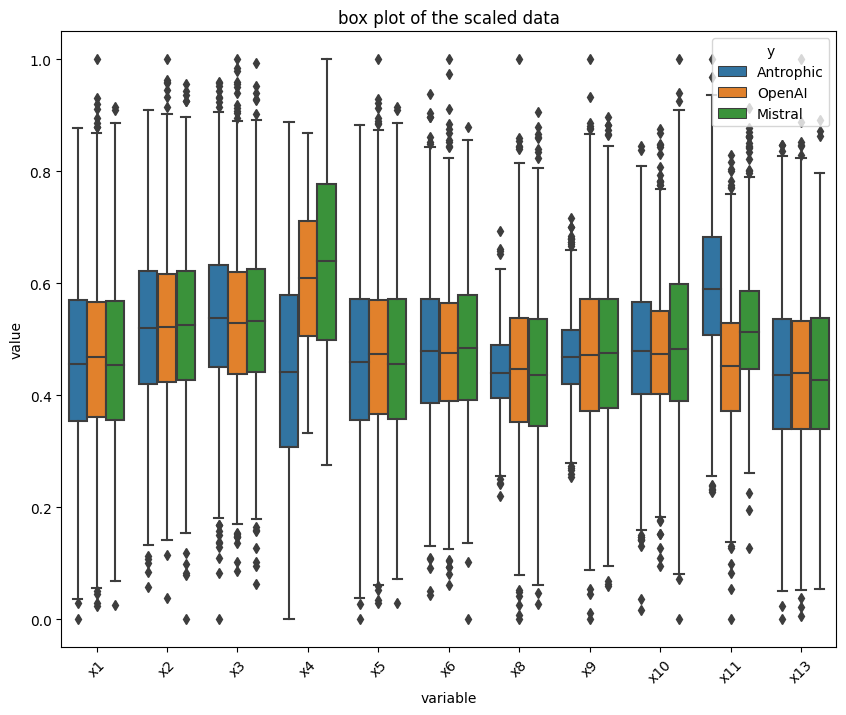

In [54]:
melt_df = pd.melt(df_scaled, id_vars=['y'], value_vars=numeric_cols)
plt.figure(figsize=(10,8))
sns.boxplot(data=melt_df,hue="y",x='variable',y='value')     
plt.xticks(rotation=45)
plt.title('box plot of the scaled data')
plt.show()

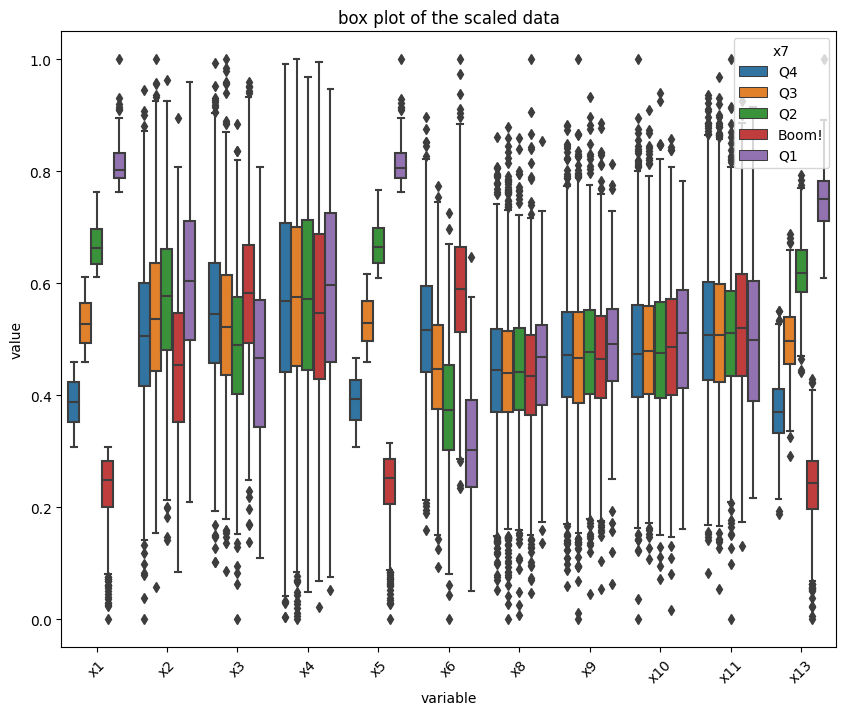

In [8]:
melt_df = pd.melt(df_scaled, id_vars=['x7'], value_vars=numeric_cols)
plt.figure(figsize=(10,8))
sns.boxplot(data=melt_df,hue="x7",x='variable',y='value')     
plt.xticks(rotation=45)
plt.title('box plot of the scaled data')
plt.show()

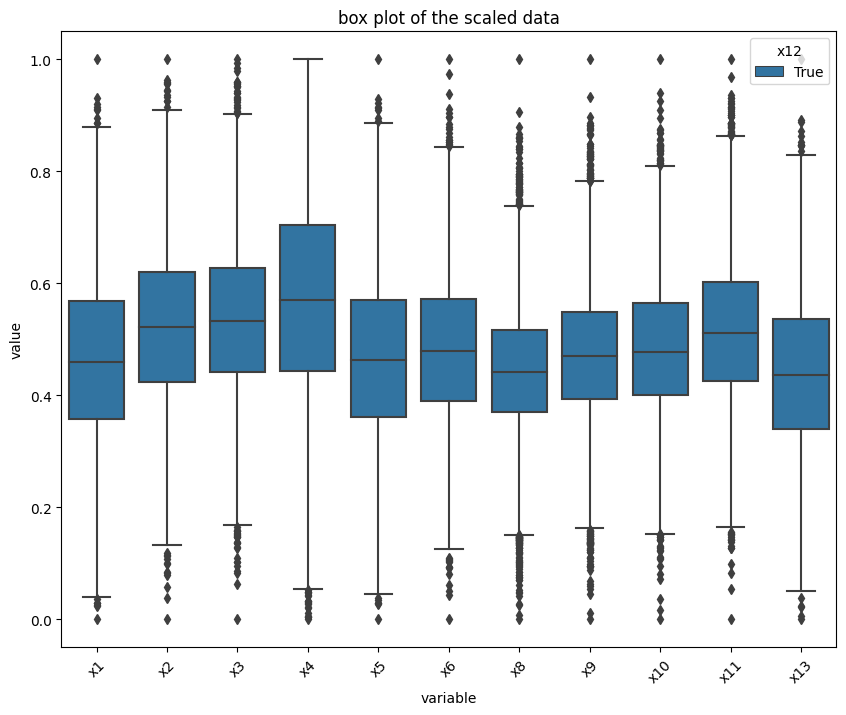

In [9]:
melt_df = pd.melt(df_scaled, id_vars=['x12'], value_vars=numeric_cols)
plt.figure(figsize=(10,8))
sns.boxplot(data=melt_df,hue="x12",x='variable',y='value')     
plt.xticks(rotation=45)
plt.title('box plot of the scaled data')
plt.show()

:eyes: 

1. Features like `x3`,`x6`,`x8`,`x9` have a significant number of outliers
2. Features such as `x1`,`x2`,`x3` have a nawwor IQR, meaning low variability
3. Features like `x8`, `x9` show larger variability across categories.

:point_right: check the correlation between similar features

In [14]:
df_scaled_map = df_scaled.copy()
x7_mapping = {'Q1': 1, 'Q2': 2, 'Q3': 3, 'Q4': 4, 'Boom!': 0}
df_scaled_map['x7'] = df_scaled_map['x7'].map(x7_mapping)

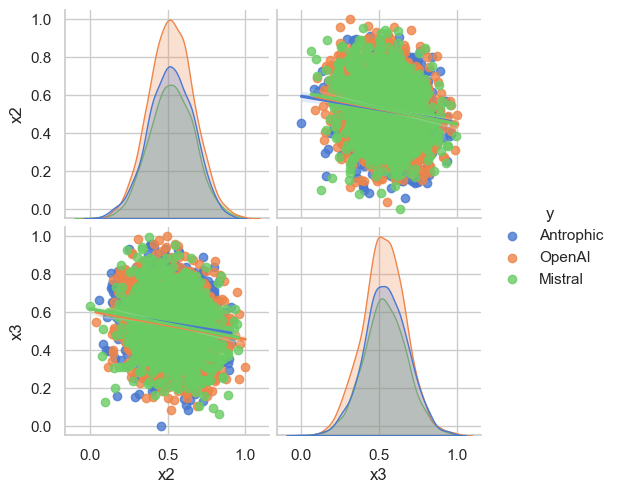

In [15]:
paired_cols = ['x2','x3','y']
sns.pairplot(df_scaled_map[paired_cols], hue="y", kind='reg', diag_kind='kde')
plt.show()

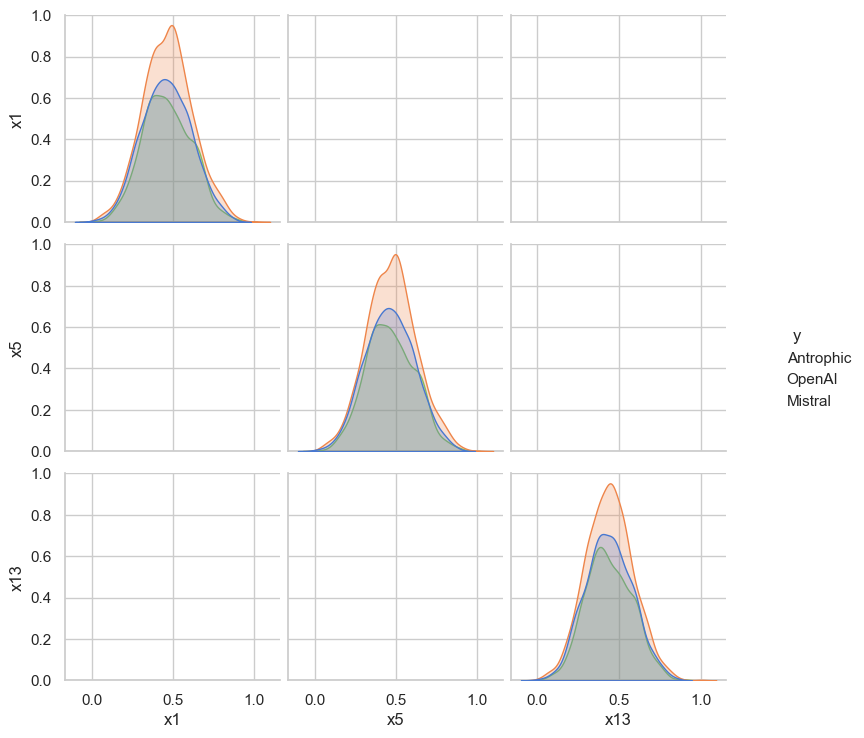

In [16]:
paired_cols = ['x1','x5','x13','y']
sns.pairplot(df_scaled_map[paired_cols], hue="y", kind='bbreg', diag_kind='kde')
plt.show()

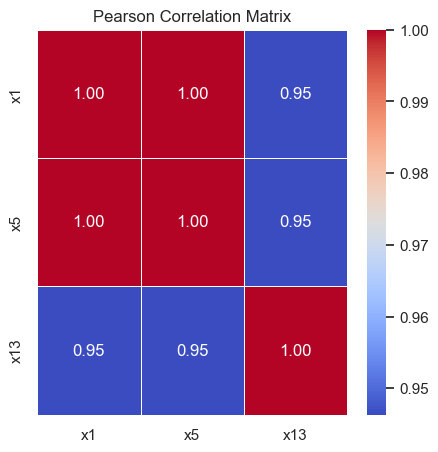

In [122]:
# Compute Pearson correlation matrix
corr_matrix = df_scaled[["x1", "x5","x13"]].corr(method="spearman")

# Display heatmap of correlation matrix
plt.figure(figsize=(5, 5))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Pearson Correlation Matrix")
plt.show()


In [18]:
df_scaled_map

y        x1        x2        x3        x4        x5        x6  \
0     Antrophic  0.436653  0.473671  0.773099  0.204398  0.441492  0.552753   
1        OpenAI  0.424449  0.638269  0.592503  0.517464  0.430921  0.686871   
2     Antrophic  0.522151  0.512536  0.638422  0.288745  0.525102  0.406388   
3     Antrophic  0.670999  0.626022  0.308974  0.481501  0.669326  0.481859   
4        OpenAI  0.399266  0.364351  0.779492  0.725226  0.402149  0.366872   
...         ...       ...       ...       ...       ...       ...       ...   
4995     OpenAI  0.458361  0.436744  0.707405  0.451229  0.466511  0.361938   
4996     OpenAI  0.239775  0.263643  0.502802  0.426908  0.247947  0.653037   
4997    Mistral  0.281773  0.391506  0.556538  0.771022  0.282566  0.668284   
4998     OpenAI  0.486445  0.445210  0.485878  0.464942  0.492333  0.493940   
4999  Antrophic  0.579267  0.824319  0.650660  0.261837  0.583963  0.472731   

      x7        x8        x9       x10       x11   x12       x13  
0      4  0.455996  0.524635  0.586149  0.644669  True  0.493108  
1      4  0.416223  0.489549  0.641718  0.510412  True  0.421218  
2      3  0.430692  0.546265  0.429107  0.545046  True  0.530167  
3      2  0.447980  0.433162  0.484336  0.583450  True  0.563028  
4      4  0.490008  0.694217  0.420840  0.333538  True  0.459404  
...   ..       ...       ...       ...       ...   ...       ...  
4995   4  0.300438  0.417984  0.402148  0.315497  True  0.492018  
4996   0  0.394470  0.666510  0.523991  0.462730  True  0.214316  
4997   0  0.404316  0.535617  0.525800  0.504247  True  0.272480  
4998   3  0.383222  0.572854  0.451776  0.281605  True  0.445101  
4999   3  0.461060  0.534080  0.725905  0.451321  True  0.588990  

[5000 rows x 14 columns]

<AxesSubplot: >

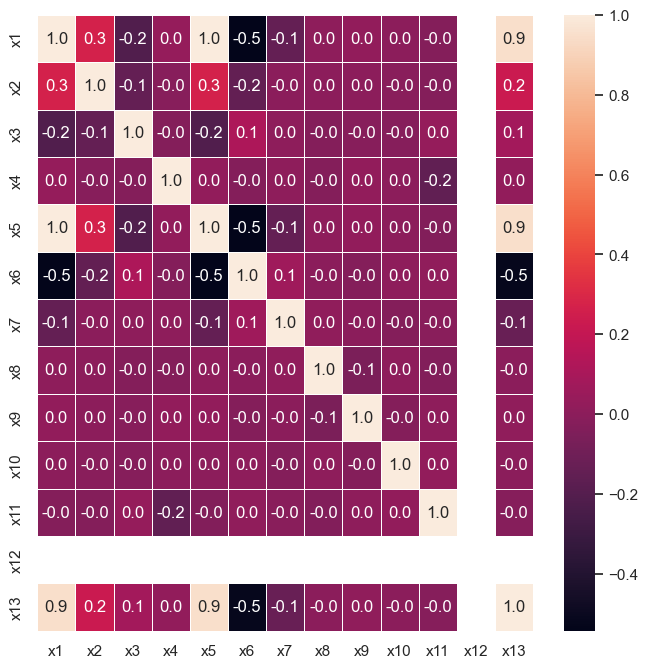

In [17]:
f,ax = plt.subplots(figsize=(8, 8))
sns.heatmap(df_scaled_map.corr('spearman'), annot=True, linewidths=.5, fmt= '.1f',ax=ax)

In [ ]:
groups = [df_scaled_map[df_scaled_map['x7'] == cat]['x1'] for cat in df_scaled_map['x7'].unique()]
f_stat, p_value = f_oneway(*groups)
print(f"ANOVA F-statistic: {f_stat:.4f}, p-value: {p_value:.4f}")

ANOVA F-statistic: 12697.5648, p-value: 0.0000


`x7` and `x1` are strongly related

In [22]:
groups = [df_scaled_map[df_scaled_map['x7'] == cat]['x6'] for cat in df_scaled_map['x7'].unique()]
f_stat, p_value = f_oneway(*groups)

print(f"ANOVA F-statistic: {f_stat:.4f}, p-value: {p_value:.4f}")


ANOVA F-statistic: 481.9455, p-value: 0.0000


:eyes:

1. `x1, x5, x13` has strong correlation with each other
2. we need to do feature engineering before we feed the model

## 4. Feature engineering

in this case, i would drop `x1` and `x5` since they are nearly identical, and keep `x13` as a representative feature

In [32]:
df_1 = df.drop(['x1','x5','x12'],axis=1)
print(df_1.iloc[:,1:].shape)

(5000, 10)


<AxesSubplot: >

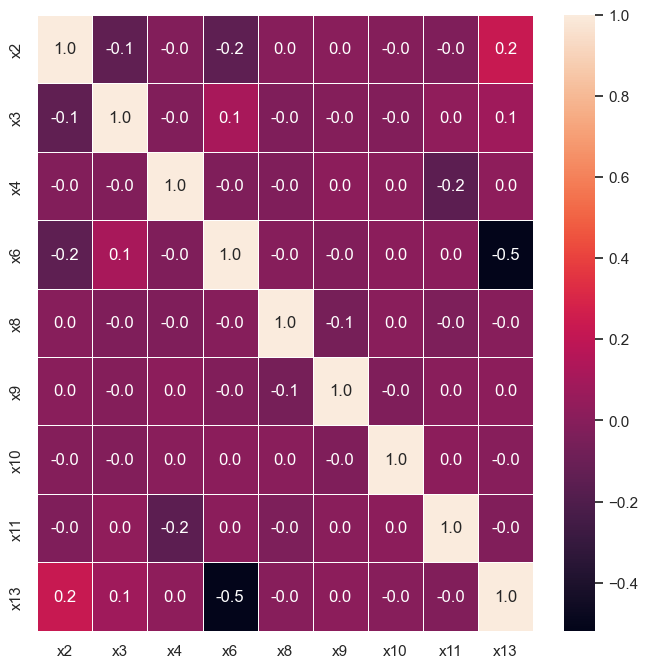

In [26]:
f,ax = plt.subplots(figsize=(8, 8))
df_1_scales = df_1.copy()
numeric_cols = df_1_scales.select_dtypes(include=[np.number]).columns.tolist()
df_1_scales[numeric_cols] = scaler.fit_transform(df_1_scales[numeric_cols])
sns.heatmap(df_1_scales.corr('spearman'), annot=True, linewidths=.5, fmt= '.1f',ax=ax)

:tractor: split the train and validation data

In [33]:
#x7_mapping = {'Q1': 1, 'Q2': 2, 'Q3': 3, 'Q4': 4, 'Boom!': 0}
#df_1['x7'] = df_1['x7'].map(x7_mapping)
#df_1 = pd.get_dummies(df_1, columns=['x7'], drop_first=True)
df_1['x7'] = df_1['x7'].astype('category')

In [34]:
df_1['x13_x7_interaction'] = df_1['x13'] * df_1['x7'].astype('category').cat.codes
df_1['x6_x7_interaction'] = df_1['x6'] * df_1['x7'].astype('category').cat.codes

In [35]:
y_mapping = {'OpenAI': 0, 'Antrophic': 1, 'Mistral': 2}
df_1['y'] = df_1['y'].map(y_mapping)

In [36]:
y = df_1['y']
X = df_1.drop(['y'],axis=1)

In [43]:
categorical_features = ["x7"]  # x7 is categorical
numerical_features = [col for col in X.columns if col not in categorical_features]

## 5. model fitting

### 1. Tree-based Ensemble Methods

good for handling non-linearity, outliers and feature interactions

- random forest

In [44]:
# Define Random Forest model
rf_model = RandomForestClassifier(max_depth=5, min_samples_split=5, n_estimators=200, random_state=SEED)
preprocessor = ColumnTransformer(
    transformers = [
    ("scaler", MinMaxScaler(),numerical_features) 
])

pipeline = Pipeline([
    ("preprocessor", preprocessor),  # Apply scaling to numeric, encoding to categorical
    ("model", rf_model)  # Train Random Forest
])
# Stratified K-Fold setup
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)

train_scores = []
val_scores = []

# Manually perform cross-validation to compute both train and validation accuracy
for train_index, val_index in kf.split(X, y):
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]
    
    # Train model
    pipeline.fit(X_train, y_train)
    
    # Evaluate on training data
    train_acc = accuracy_score(y_train, pipeline.predict(X_train))
    train_scores.append(train_acc)
    
    # Evaluate on validation data
    val_acc = accuracy_score(y_val, pipeline.predict(X_val))
    val_scores.append(val_acc)

# Print results
print(f'Training Accuracy Scores: {train_scores}')
print(f'Validation Accuracy Scores: {val_scores}')
print(f'Mean Training Accuracy: {np.mean(train_scores):.4f} +/- {np.std(train_scores):.4f}')
print(f'Mean Validation Accuracy: {np.mean(val_scores):.4f} +/- {np.std(val_scores):.4f}')

# Overfitting Check
if np.mean(train_scores) - np.mean(val_scores) > 0.05:
    print("⚠️ Warning: Possible Overfitting! Training accuracy is much higher than validation accuracy.")
else:
    print("✅ No major overfitting detected.")


Training Accuracy Scores: [0.69025, 0.68825, 0.691, 0.69775, 0.695]
Validation Accuracy Scores: [0.677, 0.666, 0.67, 0.649, 0.662]
Mean Training Accuracy: 0.6925 +/- 0.0034
Mean Validation Accuracy: 0.6648 +/- 0.0093
✅ No major overfitting detected.


In [162]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10],
    'min_samples_split': [2, 5, 10]
}

grid_search = GridSearchCV(RandomForestClassifier(random_state=SEED), param_grid, cv=5, scoring='accuracy',return_train_score=True)
grid_search.fit(X, y)
print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

Best Parameters: {'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 200}
Best Score: 0.689


In [164]:
train_scores = grid_search.cv_results_['mean_train_score']
test_scores = grid_search.cv_results_['mean_test_score']
print(f"Best Training Accuracy: {max(train_scores):.4f}")
print(f"Best Validation Accuracy: {grid_search.best_score_:.4f}")

Best Training Accuracy: 1.0000
Best Validation Accuracy: 0.6890


In [45]:
# Define the Optuna objective function
def objective(trial):
    # Suggest hyperparameters
    n_estimators = trial.suggest_int("n_estimators", 100, 1000, step=100)
    max_depth = trial.suggest_int("max_depth", 5, 50, step=5)
    min_samples_split = trial.suggest_int("min_samples_split", 2, 20, step=2)
    min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 10, step=1)
    max_features = trial.suggest_categorical("max_features", ["sqrt", "log2", None])

    # Define Random Forest model
    rf_model = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        max_features=max_features,
        random_state=42
    )
    preprocessor = ColumnTransformer(
        transformers = [
        ("scaler", MinMaxScaler(),numerical_features) 
    ])
    
    pipeline = Pipeline([
        ("preprocessor", preprocessor),  # Apply scaling to numeric, encoding to categorical
        ("model", rf_model)  # Train Random Forest
    ])

    # Set up Stratified K-Fold Cross-Validation
    kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    train_scores = []
    val_scores = []

    # Perform cross-validation manually to get both train and validation accuracy
    for train_index, val_index in kf.split(X, y):
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]

        # Train the model
        pipeline.fit(X_train, y_train)

        # Compute training accuracy
        train_acc = accuracy_score(y_train, pipeline.predict(X_train))
        train_scores.append(train_acc)

        # Compute validation accuracy
        val_acc = accuracy_score(y_val, pipeline.predict(X_val))
        val_scores.append(val_acc)

    # Compute mean train and validation accuracy
    mean_train_acc = np.mean(train_scores)
    mean_val_acc = np.mean(val_scores)

    # Log results
    trial.set_user_attr("train_accuracy", mean_train_acc)
    trial.set_user_attr("val_accuracy", mean_val_acc)

    # Return validation accuracy for optimization
    return mean_val_acc

# Run Optuna Optimization
study = optuna.create_study(direction="maximize")  # Maximize validation accuracy
study.optimize(objective, n_trials=5)

# Print Best Parameters
best_trial = study.best_trial
print("Best Parameters:", best_trial.params)
print(f"Best Validation Accuracy: {best_trial.value:.4f}")
print(f"Best Training Accuracy: {best_trial.user_attrs['train_accuracy']:.4f}")

# Overfitting Check
overfit_gap = best_trial.user_attrs['train_accuracy'] - best_trial.value
if overfit_gap > 0.05:
    print("⚠️ Warning: Possible Overfitting! Training accuracy is much higher than validation accuracy.")
else:
    print("✅ No major overfitting detected.")


[I 2025-03-06 16:04:16,748] A new study created in memory with name: no-name-81438e76-7a56-448c-8b24-34ec23c955fe
[I 2025-03-06 16:04:22,513] Trial 0 finished with value: 0.6818000000000001 and parameters: {'n_estimators': 100, 'max_depth': 50, 'min_samples_split': 12, 'min_samples_leaf': 4, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.6818000000000001.
[I 2025-03-06 16:04:57,830] Trial 1 finished with value: 0.6796 and parameters: {'n_estimators': 200, 'max_depth': 20, 'min_samples_split': 8, 'min_samples_leaf': 2, 'max_features': None}. Best is trial 0 with value: 0.6818000000000001.
[I 2025-03-06 16:05:27,444] Trial 2 finished with value: 0.6857999999999999 and parameters: {'n_estimators': 600, 'max_depth': 20, 'min_samples_split': 16, 'min_samples_leaf': 8, 'max_features': 'sqrt'}. Best is trial 2 with value: 0.6857999999999999.
[I 2025-03-06 16:06:13,578] Trial 3 finished with value: 0.6864 and parameters: {'n_estimators': 900, 'max_depth': 40, 'min_samples_split': 16, '

Best Parameters: {'n_estimators': 900, 'max_depth': 40, 'min_samples_split': 16, 'min_samples_leaf': 6, 'max_features': 'log2'}
Best Validation Accuracy: 0.6864
Best Training Accuracy: 0.8603
⚠️ Warning: Possible Overfitting! Training accuracy is much higher than validation accuracy.


1. feature engineering by remove not important features

In [174]:
rf_model = RandomForestClassifier(n_estimators=200, max_depth=50, min_samples_split=20, min_samples_leaf=4, max_features='log2', random_state=SEED)
rf_model.fit(X, y)
feature_importances = pd.Series(rf_model.feature_importances_, index=X.columns)
print(feature_importances.sort_values(ascending=False))


x4       0.266616
x11      0.214889
x9       0.132796
x8       0.128609
x10      0.078475
x6       0.043006
x2       0.042613
x3       0.041229
x13      0.039264
x7_Q3    0.004471
x7_Q4    0.004432
x7_Q2    0.003024
x7_Q1    0.000578
x12      0.000000
dtype: float64


In [176]:
# Drop low-importance features
X_filtered = X.drop(columns=['x7_Q3', 'x7_Q4', 'x7_Q2', 'x7_Q1', 'x12'])

# Retrain model
rf_model_filtered = RandomForestClassifier(n_estimators=200, max_depth=5, min_samples_split=20, min_samples_leaf=4,max_features='log2', random_state=SEED)
rf_model_filtered.fit(X_filtered, y)

# Evaluate new performance
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)
cv_scores_filtered = cross_val_score(rf_model_filtered, X_filtered, y, cv=kf, scoring="accuracy")

print(f"New Mean Validation Accuracy: {np.mean(cv_scores_filtered):.4f} ± {np.std(cv_scores_filtered):.4f}")

New Mean Validation Accuracy: 0.6638 ± 0.0105


In [ ]:
# L1 Regularized Logistic Regression (LASSO)
lasso = LogisticRegression(penalty="l1", solver="liblinear", C=0.1)  # C is the regularization strength
X_lasso = X.copy()
lasso.fit(X_lasso, y)

# Select important featuresb
selector = SelectFromModel(lasso, prefit=True)
X_lasso_selected = selector.transform(X)

print("Selected Features:", X_lasso.columns[selector.get_support()])


Selected Features: Index(['x2', 'x3', 'x6', 'x8', 'x9', 'x10', 'x11', 'x13', 'x7_Q2', 'x7_Q3',
       'x7_Q4'],
      dtype='object')


1. remove low 

- gradient boosting

In [ ]:
# Define the Optuna objective function
def objective(trial):
    # Suggest hyperparameters
    n_estimators = trial.suggest_int("n_estimators", 100, 1000, step=100)
    max_depth = trial.suggest_int("max_depth", 3, 15, step=2)
    learning_rate = trial.suggest_loguniform("learning_rate", 0.01, 0.3)
    subsample = trial.suggest_uniform("subsample", 0.5, 1.0)
    colsample_bytree = trial.suggest_uniform("colsample_bytree", 0.5, 1.0)
    min_child_weight = trial.suggest_int("min_child_weight", 1, 10)

    # Define XGBoost model
    xgb_model = XGBClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        learning_rate=learning_rate,
        subsample=subsample,
        colsample_bytree=colsample_bytree,
        min_child_weight=min_child_weight,
        random_state=42,
        use_label_encoder=False,
        eval_metric="logloss"
    )

    preprocessor = ColumnTransformer(
        transformers = [
        ("scaler", MinMaxScaler(),numerical_features) 
    ])

    pipeline = Pipeline([
        ("preprocessor", preprocessor),  # Apply scaling to numeric, encoding to categorical
        ("model", xgb_model)  # Train Random Forest
    ])

    # Perform cross-validation
    kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_val_score(pipeline, X, y, cv=kf, scoring="accuracy")

    return scores.mean()  # Optuna maximizes this

# Run Optuna Optimization
study = optuna.create_study(direction="maximize")  # Maximize validation accuracy
study.optimize(objective, n_trials=5)  # Run 50 trials

# Print Best Parameters
best_trial = study.best_trial
print("Best Parameters:", best_trial.params)
print(f"Best Validation Accuracy: {best_trial.value:.4f}")


[I 2025-03-06 16:08:15,402] A new study created in memory with name: no-name-9c4b3738-eaf7-4396-a4b8-a6e1a1137415


In [205]:
import plotly.io as pio
pio.renderers.default = "notebook"  # For inline rendering
# Alternative: pio.renderers.default = "browser"  # Opens in a browser

# Define a target function to extract AUC from each trial
def target_for_auc(trial):
    return trial.values[0]  # AUC is the first value in the multi-objective optimization

# Use the target function in the plot_slice
optuna.visualization.plot_slice(study, target=target_for_auc)

In [206]:
optuna.visualization.plot_param_importances(study)

### 2. SVM